This tutorial measures the runtime of Global PDP plots, which are influenced by several factors:

- $t$: How heavy the ML model is, i.e., how fast a single evaluation of the model is.
- $N$: The number of instances.
- $D$: The number of features.
- $T$: Number of points used for centering the PDP plot, if needed.
- $T$: The number of points we ask to evaluate on.

We refer to both the points used for centering and the points to evaluate as $T$, because in practice, centering a PDP plot requires evaluating $T$ points.

In this tutorial, we'll focus on $t$, $N$, and $D$ to measure how each influences the runtime of Global PDP.

In Effector, we have two PDP implementations:
- A vectorized version (faster but with higher memory demands)
- A non-vectorized version (slower but uses less memory)

The vectorized version internally creates a matrix of size $(T \times N, D)$, which can challenge memory capacity. We aim to show that, when memory allows, the vectorized option is the better choice.

In [4]:
import effector
import numpy as np
import timeit
import time
import matplotlib.pyplot as plt
np.random.seed(21)

In [5]:
def return_predict(t):
    def predict(x):
        time.sleep(t)
        model = effector.models.DoubleConditionalInteraction()
        return model.predict(x)
    return predict

def return_jacobian(t):
    def jacobian(x):
        time.sleep(t)
        model = effector.models.DoubleConditionalInteraction()
        return model.jacobian(x)
    return jacobian

In [3]:
def measure_time(repetitions):
    pdp_times = []
    for _ in range(repetitions):
        X = np.random.uniform(-1, 1, (N, D))
        xx = np.linspace(-1, 1, T)

        axis_limits = np.zeros((2,D))
        axis_limits[0, :] = -1
        axis_limits[1, :] = 1
        
        start_time = time.time()
        
        pdp = effector.PDP(data=X, model=return_predict(t), axis_limits=axis_limits)
        pdp.fit("all", centering=True, points_for_centering=T, use_vectorized=use_vectorized)
        pdp.eval(feature=0, xs=xx, centering=True, heterogeneity=True)
    
        pdp_times.append(time.time() - start_time)
    return np.mean(pdp_times)/3

## PDP time vs t (time for a single evaluation of f)

In [4]:
t = 0.001
N = 10_000
D = 10
T = 100

In [5]:
vec = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1]
time_vectorized = []
time_non_vectorized = []
for t in vec:
    use_vectorized = True
    time_vectorized.append(measure_time(3))

    use_vectorized = False
    time_non_vectorized.append(measure_time(3))

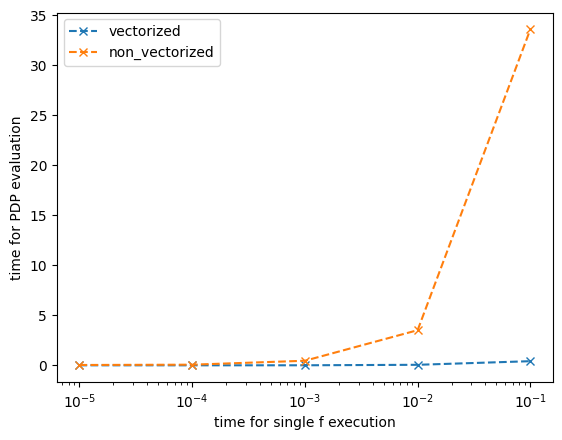

In [6]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(vec, time_vectorized, "x--", label="vectorized")
plt.plot(vec, time_non_vectorized, "x--", label="non_vectorized")
plt.xlabel("time for single f execution")
plt.ylabel("time for PDP evaluation")
plt.xscale("log")
plt.legend()
plt.show()

## PDP time vs N (nof instances)

In [7]:
t = 0.001
N = 10_000
D = 10
T = 100

In [8]:
vec = [1_000, 10_000, 50_000, 100_000]
time_vectorized = []
time_non_vectorized = []
for N in vec:
    use_vectorized = True
    time_vectorized.append(measure_time(3))

    use_vectorized = False
    time_non_vectorized.append(measure_time(3))

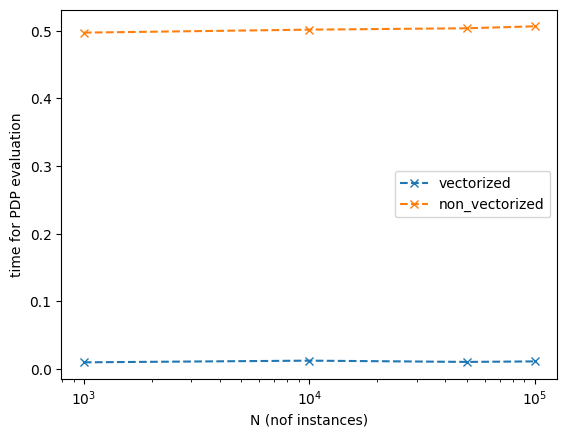

In [9]:
plt.figure()
plt.plot(vec, time_vectorized, "x--", label="vectorized")
plt.plot(vec, time_non_vectorized, "x--", label="non_vectorized")
plt.xlabel("N (nof instances)")
plt.ylabel("time for PDP evaluation")
plt.xscale("log")
plt.legend()
plt.show()

## PDP time vs D (nof features)

In [10]:
t = 0.001
N = 10_000
T = 100

In [11]:
vec = [5, 10, 50, 100]
time_vectorized = []
time_non_vectorized = []
for D in vec:
    use_vectorized = True
    time_vectorized.append(measure_time(3))

    use_vectorized = False
    time_non_vectorized.append(measure_time(3))

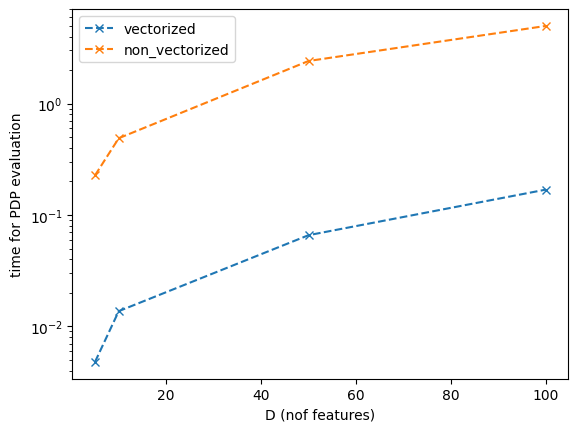

In [13]:
plt.figure()
plt.plot(vec, time_vectorized, "x--", label="vectorized")
plt.plot(vec, time_non_vectorized, "x--", label="non_vectorized")
plt.xlabel("D (nof features)")
plt.ylabel("time for PDP evaluation")
plt.yscale("log")
plt.legend()
plt.show()

## Conclusion

In practice, the vectorized version outperforms the non-vectorized version in all cases:

- The runtime of the black-box model is the key factor. As the model size increases, the non-vectorized implementation shows a linear increase in runtime, while the vectorized implementation remains unaffected.
- The number of instances does not significantly impact the runtime for either version, as long as \( y \) can be obtained in a single pass of \( f(x) \).
- Both versions scale linearly with the number of features, but the vectorized version is consistently faster by a constant margin.